In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sundarannamalai_hair_diseases_path = kagglehub.dataset_download('sundarannamalai/hair-diseases')

print('Data source import complete.')


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
IMAGE_SIZE = [224, 224]

train_path = r'../input/hair-diseases/Hair Diseases - Final/train'
test_path = r'../input/hair-diseases/Hair Diseases - Final/test'
val_path = r'../input/hair-diseases/Hair Diseases - Final/val'

In [ ]:
#Load Pretrained ResNet50 Model
resnet = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#Freezes all ResNet50 layers so their weights are not updated during training.
for layer in resnet.layers:
    layer.trainable = False

94781440/94765736 [==============================] - 3s 0us/step


In [ ]:
# Get the number of classes from the training directory
folders = glob(train_path + '/*')
num_classes = len(folders)

# Build custom classifier on top of ResNet50
x = Flatten()(resnet.output)
prediction = Dense(num_classes, activation='softmax')(x)
# Create model
model = Model(inputs=resnet.input, outputs=prediction)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
# ImageDataGenerator is used to load, preprocess, and augment images.  scales pixel values from [0, 255] to [0, 1]
train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True
                                  )
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)
# Load images from folders
train_set = train_datagen.flow_from_directory(directory=train_path,
                                                target_size = (224,224),
                                                batch_size = 64,
                                                class_mode = 'categorical')
test_set = test_datagen.flow_from_directory(directory=test_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical', shuffle=False)
val_set = val_datagen.flow_from_directory(directory=val_path,
                                            target_size = (224,224),
                                            batch_size = 64,
                                            class_mode = 'categorical', shuffle=False)

Found 9600 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.
Found 1200 images belonging to 10 classes.


In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
                  train_set,
                  validation_data=val_set,
                  epochs=20,
                  batch_size=128,
                  steps_per_epoch=len(train_set),
                  validation_steps=len(test_set)
                )

Epoch 1/20
150/150 [==============================] - 201s 1s/step - loss: 3.2180 - accuracy: 0.2101 - val_loss: 2.2861 - val_accuracy: 0.3200
Epoch 2/20
150/150 [==============================] - 157s 1s/step - loss: 2.2306 - accuracy: 0.2686 - val_loss: 2.3555 - val_accuracy: 0.2633
Epoch 3/20
150/150 [==============================] - 156s 1s/step - loss: 2.0475 - accuracy: 0.3155 - val_loss: 1.8591 - val_accuracy: 0.4117
Epoch 4/20
150/150 [==============================] - 156s 1s/step - loss: 2.0227 - accuracy: 0.3320 - val_loss: 1.8951 - val_accuracy: 0.3675
Epoch 5/20
150/150 [==============================] - 157s 1s/step - loss: 2.0081 - accuracy: 0.3377 - val_loss: 1.7902 - val_accuracy: 0.3717
Epoch 6/20
150/150 [==============================] - 156s 1s/step - loss: 1.9378 - accuracy: 0.3679 - val_loss: 1.9342 - val_accuracy: 0.4217
Epoch 7/20
150/150 [==============================] - 157s 1s/step - loss: 2.1104 - accuracy: 0.3545 - val_loss: 1.6548 - val_accuracy: 0.4150

In [ ]:
model.save("ResNet50-Final.h5")
print("Model Saved as : ResNet50-Final.h5")

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model Saved as : ResNet50-Final.h5


In [ ]:
evl = model.evaluate(test_set)

test_loss, test_acc = evl[0]*100, evl[1]*100


print(f'Test Accuracy = {test_acc} %')
print(f'Test Loss = {test_loss} %')

19/19 [==============================] - 12s 630ms/step - loss: 1.2978 - accuracy: 0.5708
Test Accuracy = 57.083332538604736 %
Test Loss = 129.7796368598938 %


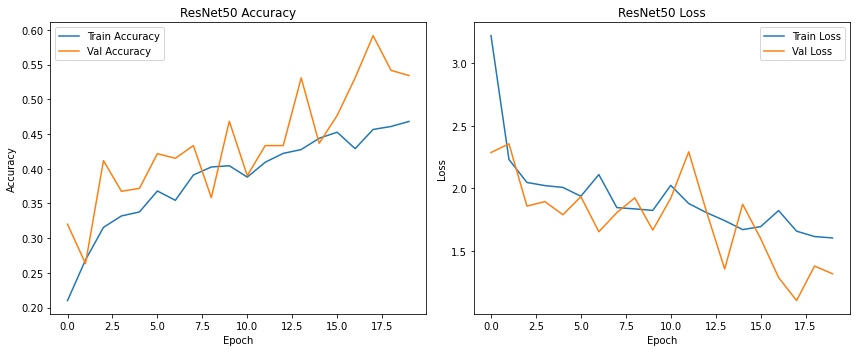

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('ResNet50 Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


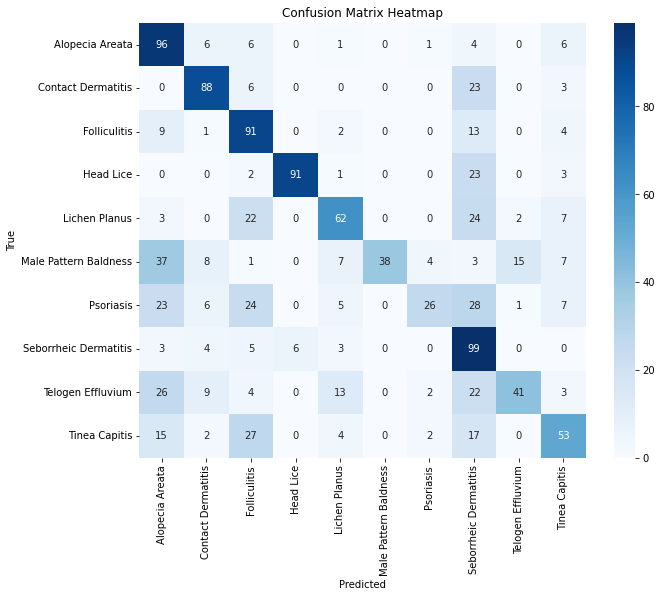

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get true labels and predicted labels
true_labels = test_set.classes
pred_probs = model.predict(test_set)
pred_labels = np.argmax(pred_probs, axis=1)

# Class names
class_names = list(test_set.class_indices.keys())

# Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


Found 1200 images belonging to 10 classes.


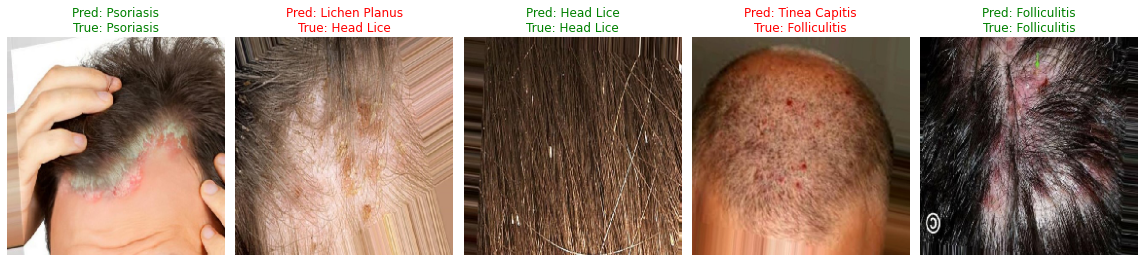

In [ ]:
import random


# Get test images and true labels
x_test, y_true = next(test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=1000,  # large batch to access many images
    class_mode='categorical',
    shuffle=False))

# Predict with the model
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_true, axis=1)

# Choose random indices to visualize
n = 5
indices = random.sample(range(len(x_test)), n)

# Plot images with predictions
plt.figure(figsize=(16, 4))
for i, idx in enumerate(indices):
    plt.subplot(1, n, i + 1)
    plt.imshow(x_test[idx])
    plt.axis('off')
    true_label = class_names[y_true_labels[idx]]
    pred_label = class_names[y_pred[idx]]
    color = "green" if true_label == pred_label else "red"
    plt.title(f"Pred: {pred_label}\nTrue: {true_label}", color=color)
plt.tight_layout()
plt.show()
